In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import contractions 
import re 
import nltk
import contractions as cr
from nltk.corpus import stopwords, words
import string
from typing import Set, Tuple, List
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from collections import Counter
from nltk.tokenize import sent_tokenize
from sklearn.preprocessing import MinMaxScaler

import tensorflow_hub as hub
# nltk.download("stopwords")

In [34]:
rating = { 1:"Satire",2:"Hoax",3:"Propaganda",4:"Reliable News"}
df = pd.read_csv("raw_data/fulltrain.csv", names = ["Rating", "Text"])
df["Rating_String"] = df["Rating"].apply(lambda x : rating[x])
train_labels = np.array(df["Rating"])
df

,Rating,Text,Rating_String
0,1,"A little less than a decade ago, hockey fans w...",Satire
1,1,The writers of the HBO series The Sopranos too...,Satire
2,1,Despite claims from the TV news outlet to offe...,Satire
3,1,After receiving 'subpar' service and experienc...,Satire
4,1,After watching his beloved Seattle Mariners pr...,Satire
...,...,...,...
48849,4,The ruling Kuomintang (KMT) has claimed owners...,Reliable News
48850,4,The Taipei city government has encouraged the ...,Reliable News
48851,4,President Ma Ying-jeou said Friday that a park...,Reliable News
48852,4,The families of the four people who were kille...,Reliable News


In [39]:
test_df = pd.read_csv("raw_data/balancedtest.csv",names = ["Rating", "Text"])
test_df_labels = test_df["Rating"]

In [3]:
two_label_df = df.copy(deep = True)
two_label_df["Rating"] = two_label_df["Rating"].apply(lambda x : 1 if x == 4 else 2)
two_label_df["Rating_String"] = two_label_df["Rating"].apply(lambda x : "Reliable News" if x == 1 else "Fake News")
two_label_df

,Rating,Text,Rating_String
0,2,"A little less than a decade ago, hockey fans w...",Fake News
1,2,The writers of the HBO series The Sopranos too...,Fake News
2,2,Despite claims from the TV news outlet to offe...,Fake News
3,2,After receiving 'subpar' service and experienc...,Fake News
4,2,After watching his beloved Seattle Mariners pr...,Fake News
...,...,...,...
48849,1,The ruling Kuomintang (KMT) has claimed owners...,Reliable News
48850,1,The Taipei city government has encouraged the ...,Reliable News
48851,1,President Ma Ying-jeou said Friday that a park...,Reliable News
48852,1,The families of the four people who were kille...,Reliable News


In [13]:
stops = set(stopwords.words('english'))
    
punct_set = set()
for each_punct in string.punctuation:
    punct_set.add(each_punct)
    
def get_top_k(data, k = 100):
    combined_text = " ".join([each_text for each_text in data["Text"]]).lower()
    all_common_words = Counter(combined_text.split(" ")).most_common()
    print(len(all_common_words))
#     All words as retrieved from Counter().most_common()
    top_words = []
    for word_pair in all_common_words:
        each_word = word_pair[0]
        if each_word.isalpha() and each_word not in stops:
            top_words.append(each_word)
    
    return set(top_words[:k])

all_common_words = get_top_k(df, k = 250)

def get_word_stats(text : str):
    """
    returns (num_characters, num_words, avg_word_len, num_numeric, num_contractions, num_capital_words, common_words_ratio, 
        unique_words_ratio)
    """
    num_capital = 0
    word_len = []
    unique_words = set()
    num_numeric = 0
    num_contractions = 0
    num_common_words = 0
    for each_word in re.split("\s+", text):
        num_contractions += (each_word in cr.contractions_dict.keys())
        if each_word.isupper():
            num_capital += 1
#         Features below normalized_word require normalization to reflect a fair score since Then Then, then are same
        normalized_word = re.sub("[^a-zA-Z0-9\s]", "", each_word).lower()    
        num_numeric += normalized_word.isnumeric()
        num_common_words += (normalized_word in all_common_words)
        word_len.append(len(normalized_word))
        unique_words.add(normalized_word)

    
    word_len_arr = np.array(word_len)
    num_chars = np.sum(word_len_arr)
    num_words = len(word_len_arr)
    avg_word_len = np.mean(word_len_arr)
    
    return num_chars, num_words, avg_word_len, num_numeric, num_contractions, num_capital,\
        num_common_words/num_words, len(unique_words)/num_words


def get_sentence_stats(text : str):
    """
    returns (num_sentences, avg_sentence_len)
    """
    sentence_lst = sent_tokenize(text)
    avg_len = np.mean([len(each_sentence.split(" ")) for each_sentence in sentence_lst])
    
    return len(sentence_lst), avg_len

def get_stopwords_punctuation(text : str): 
    """
    returns (stopword_ratio, num_punctuation)
    """
    text = text.lower()
    num_words = 0
    num_stops = 0
    for each_word in re.split("\s+", text):
        if each_word in stops:
            num_stops += 1
        num_words += 1
    
    num_punct = re.findall("[!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]",  text)
    
    return num_stops/num_words, len(num_punct)

        
    

# Gets basic statistics of a text or corpus
def gen_features(text : str) -> np.array:
    """
    returns numpy array representing basic attributes of a text
    np.array["num_characters", "num_words", "avg_word_len", num_numeric, num_contractions, 
    "num_capital_words", "common_words_ratio" "unique_words_ratio", "stopwords_ratio",
             "num_punctuation"]
    """
    
    basic_stats = np.array(get_word_stats(text))
    advanced_stats = np.array(get_stopwords_punctuation(text))
    sentence_stats = np.array(get_sentence_stats(text))
    
    return np.concatenate((basic_stats, advanced_stats, sentence_stats))

def gen_feature_df(data):
    all_added_features = data["Text"].apply(gen_features)
    col_names = ["num_characters", "num_words", "avg_word_len", "num_numeric", "num_contractions", "num_capital_words",\
                 "common_words_ratio", "unique_words_ratio", "stopwords_ratio", "num_punctuation",\
                "num_sentences", "avg_sentence_len"]
    assert len(col_names) == len(all_added_features[0])
    added_features_df = pd.DataFrame(np.array([all_added_features[i] for i in range(len(all_added_features))]), columns = col_names)
    final_df = pd.concat([data, added_features_df], axis = 1)
    print(f"{len(col_names)} features generated!")
    return final_df

597334


In [14]:
run = input("Do you want to run this [y/n]: ").strip()
if run == "y":
    print("Running...")
    all_added_features = df["Text"].apply(gen_features)

Do you want to run this [y/n]: y
Running...


In [16]:
feature_df = gen_feature_df(df)
feature_df

12 features generated!


,Rating,Text,Rating_String,num_characters,num_words,avg_word_len,num_numeric,num_contractions,num_capital_words,common_words_ratio,unique_words_ratio,stopwords_ratio,num_punctuation,num_sentences,avg_sentence_len
0,1,"A little less than a decade ago, hockey fans w...",Satire,709.0,147.0,4.823129,0.0,0.0,4.0,0.115646,0.768707,0.326531,18.0,7.0,20.857143
1,1,The writers of the HBO series The Sopranos too...,Satire,577.0,123.0,4.691057,1.0,0.0,2.0,0.186992,0.756098,0.373984,16.0,4.0,30.500000
2,1,Despite claims from the TV news outlet to offe...,Satire,3582.0,706.0,5.073654,21.0,0.0,9.0,0.131728,0.566572,0.338527,156.0,28.0,25.214286
3,1,After receiving 'subpar' service and experienc...,Satire,3063.0,706.0,4.338527,7.0,8.0,13.0,0.147309,0.507082,0.441926,145.0,26.0,27.115385
4,1,After watching his beloved Seattle Mariners pr...,Satire,842.0,174.0,4.839080,0.0,4.0,3.0,0.166667,0.718391,0.362069,43.0,7.0,24.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48849,4,The ruling Kuomintang (KMT) has claimed owners...,Reliable News,2770.0,621.0,4.460548,16.0,0.0,19.0,0.101449,0.423510,0.442834,102.0,21.0,29.523810
48850,4,The Taipei city government has encouraged the ...,Reliable News,1385.0,275.0,5.036364,3.0,0.0,0.0,0.130909,0.574545,0.443636,41.0,10.0,27.400000
48851,4,President Ma Ying-jeou said Friday that a park...,Reliable News,2132.0,405.0,5.264198,7.0,0.0,1.0,0.116049,0.538272,0.370370,61.0,12.0,33.666667
48852,4,The families of the four people who were kille...,Reliable News,1124.0,246.0,4.569106,4.0,0.0,0.0,0.162602,0.516260,0.508130,23.0,13.0,18.846154


#### EDA 

1. Average number of sentences
2. Average sentence length
3. Average number of words
4. Average word length 
5. Number of punctuations per text sample

<AxesSubplot: title={'center': 'Label Distribution (4 Labels)'}>

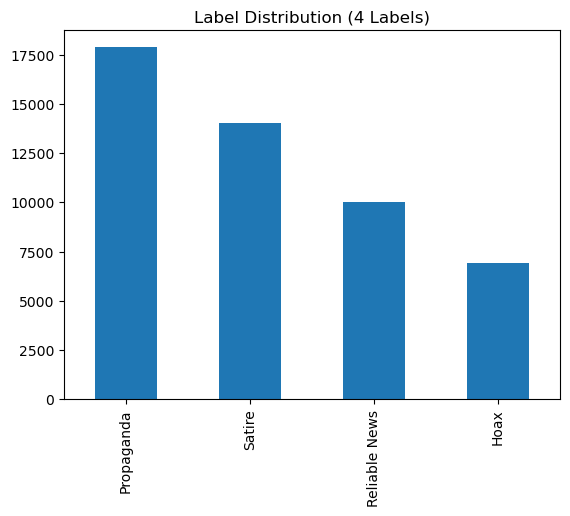

In [30]:
# data label distribution (4 labels)
df["Rating_String"].value_counts().plot(kind = "bar", title = "Label Distribution (4 Labels)")

In [22]:
rating_percent = 100 * df["Rating_String"].value_counts()/len(df)
rating_percent

Propaganda       36.578376
Satire           28.753019
Reliable News    20.458918
Hoax             14.209686
Name: Rating_String, dtype: float64

<AxesSubplot: title={'center': 'Label Distribution (2 Labels)'}>

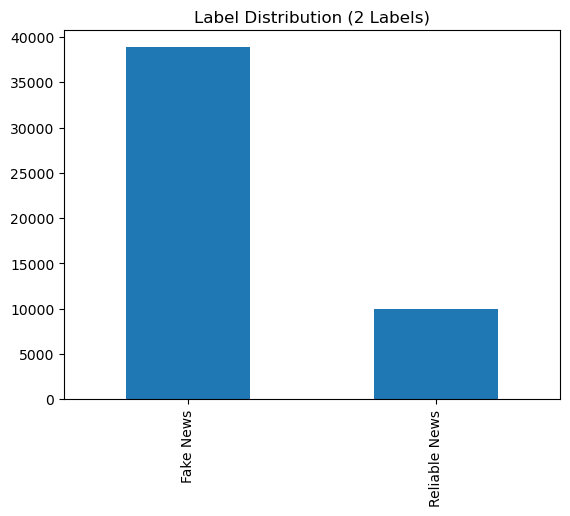

In [23]:
two_label_df["Rating_String"].value_counts().plot(kind = "bar", title = "Label Distribution (2 Labels)")

<AxesSubplot: title={'center': 'Proportion of unique words per text'}, ylabel='Frequency'>

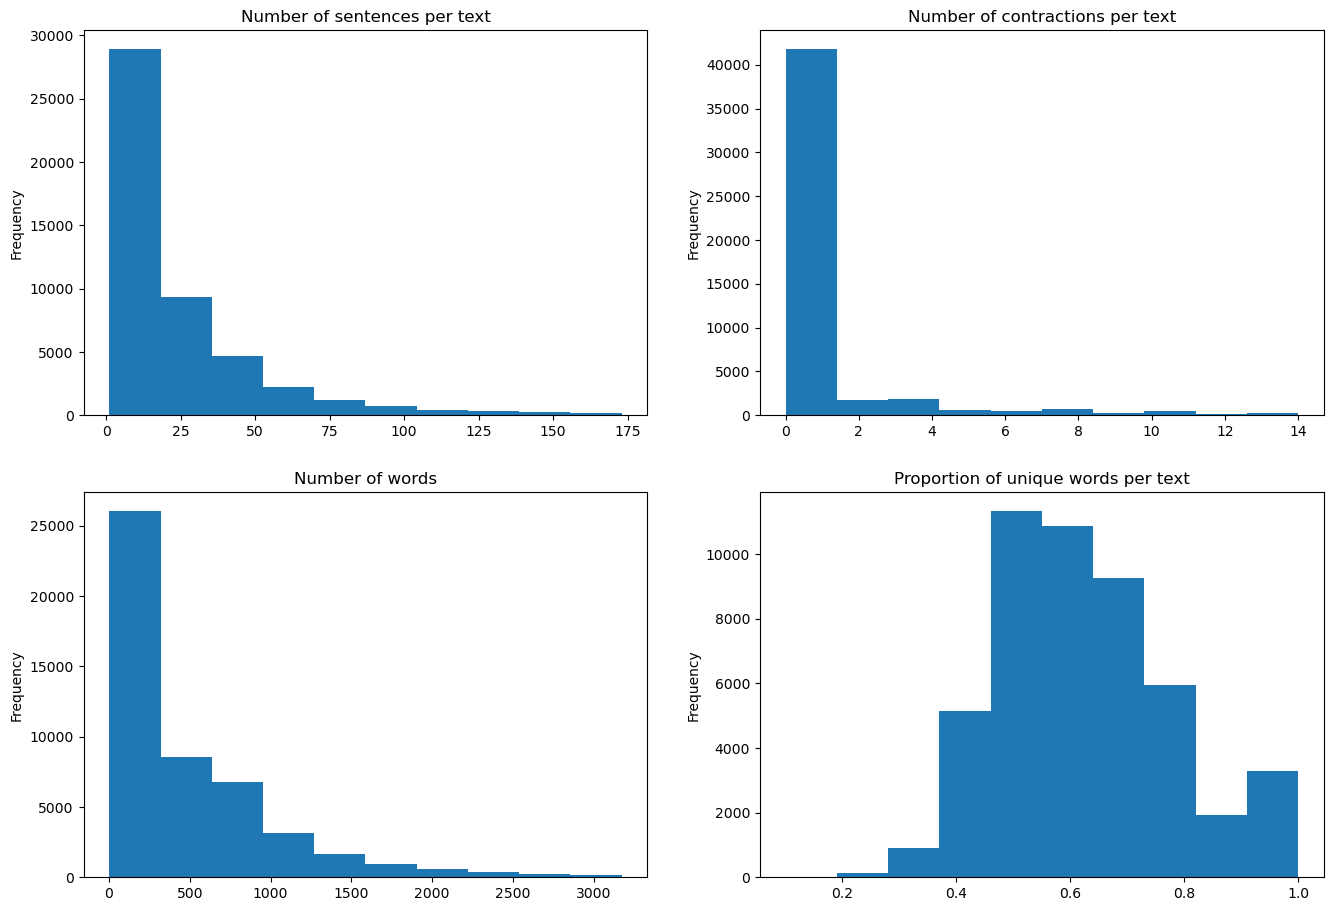

In [41]:
# Remove outliers 
def remove_outliers(data, attribute : str, quantile = 0.99):
    """
    remove outliers applied only to numerical data 
    attribute specifies to column label/identifier
    quantile specifies what proportion of data to keep so 0.99 would mean top 99% to keep
    """
    if attribute not in data.columns:
        print(f"Provided attribute {attribute} is not a valid column name!")
    cutoff = data[attribute].quantile(q = 0.99, interpolation = "lower")
    res = data[data[attribute] <= cutoff]
    return res

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (16, 11))
remove_outliers(feature_df, "num_sentences")["num_sentences"].plot(kind = "hist", ax = axes[0,0], title = "Number of sentences per text")
remove_outliers(feature_df, "num_contractions")["num_contractions"].plot(kind = "hist", ax = axes[0,1], title = "Number of contractions per text")
remove_outliers(feature_df, "num_words")["num_words"].plot(kind = "hist", ax = axes[1,0], title = "Number of words")
remove_outliers(feature_df, "unique_words_ratio")["unique_words_ratio"].plot(kind = "hist", ax = axes[1,1], title = "Proportion of unique words per text")


<AxesSubplot: title={'center': 'Proportion of stopwords per text'}, ylabel='Frequency'>

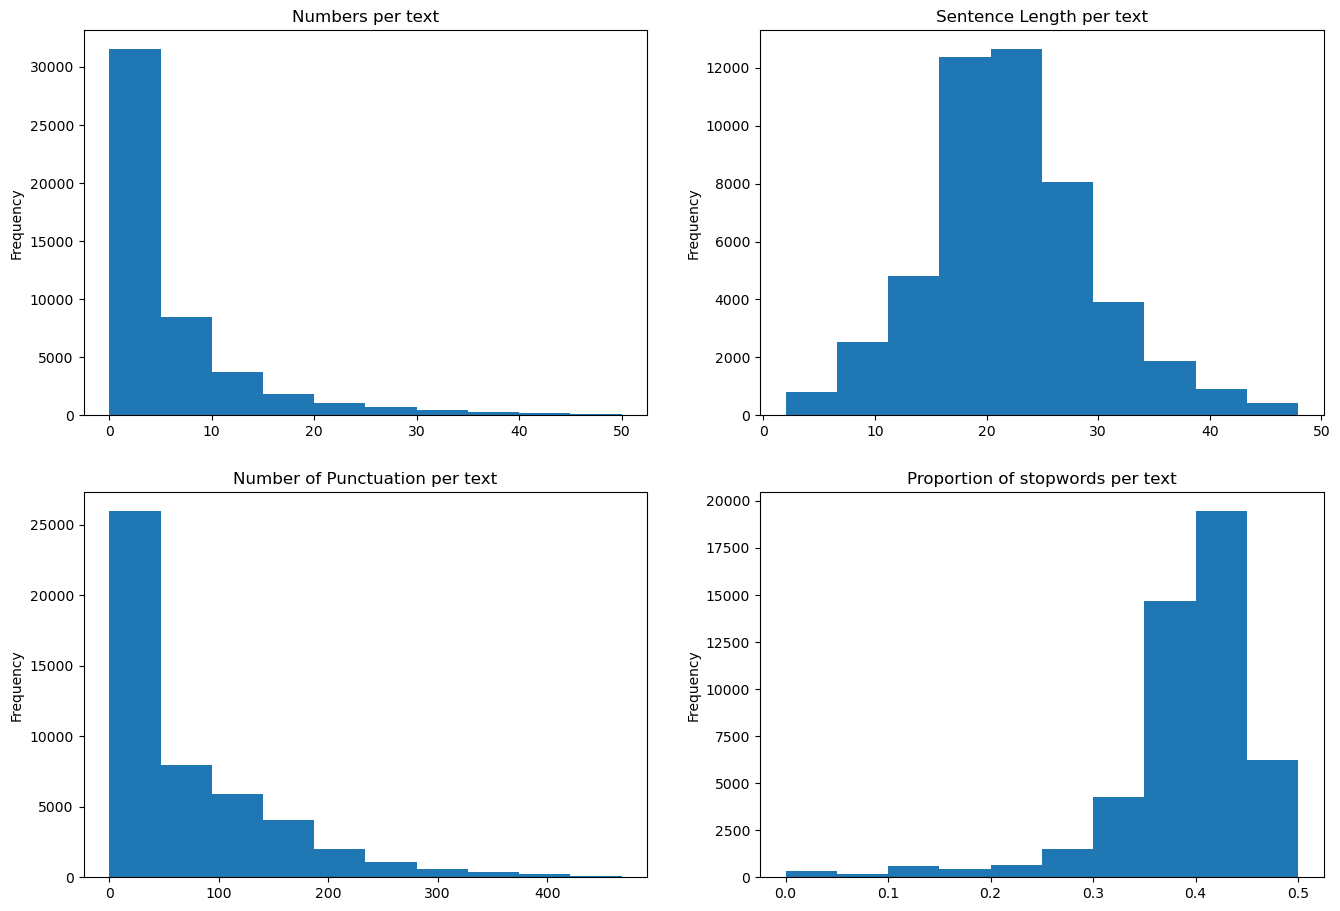

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (16, 11))

remove_outliers(feature_df, "num_numeric")["num_numeric"].plot(kind = "hist", ax = axes[0,0], title = "Numbers per text")
remove_outliers(feature_df, "avg_sentence_len")["avg_sentence_len"].plot(kind = "hist", ax = axes[0,1], title = "Sentence Length per text")
remove_outliers(feature_df, "num_punctuation")["num_punctuation"].plot(kind = "hist", ax = axes[1,0], title = "Number of Punctuation per text")
remove_outliers(feature_df, "stopwords_ratio")["stopwords_ratio"].plot(kind = "hist", ax = axes[1,1], title = "Proportion of stopwords per text")

In [77]:
final_df.groupby("Rating_String").mean()["num_sentences"]

Rating_String
Hoax             11.134111
Propaganda       45.800783
Reliable News    20.195298
Satire           12.454617
Name: num_sentences, dtype: float64

#### Grouping attributes by label class 


In [28]:
def grp_by_attr(data, attribute : List[str]):
    return remove_outliers(data, attribute).groupby("Rating_String").mean()[attribute]

<AxesSubplot: title={'center': 'Proportion of Common words for each label'}>

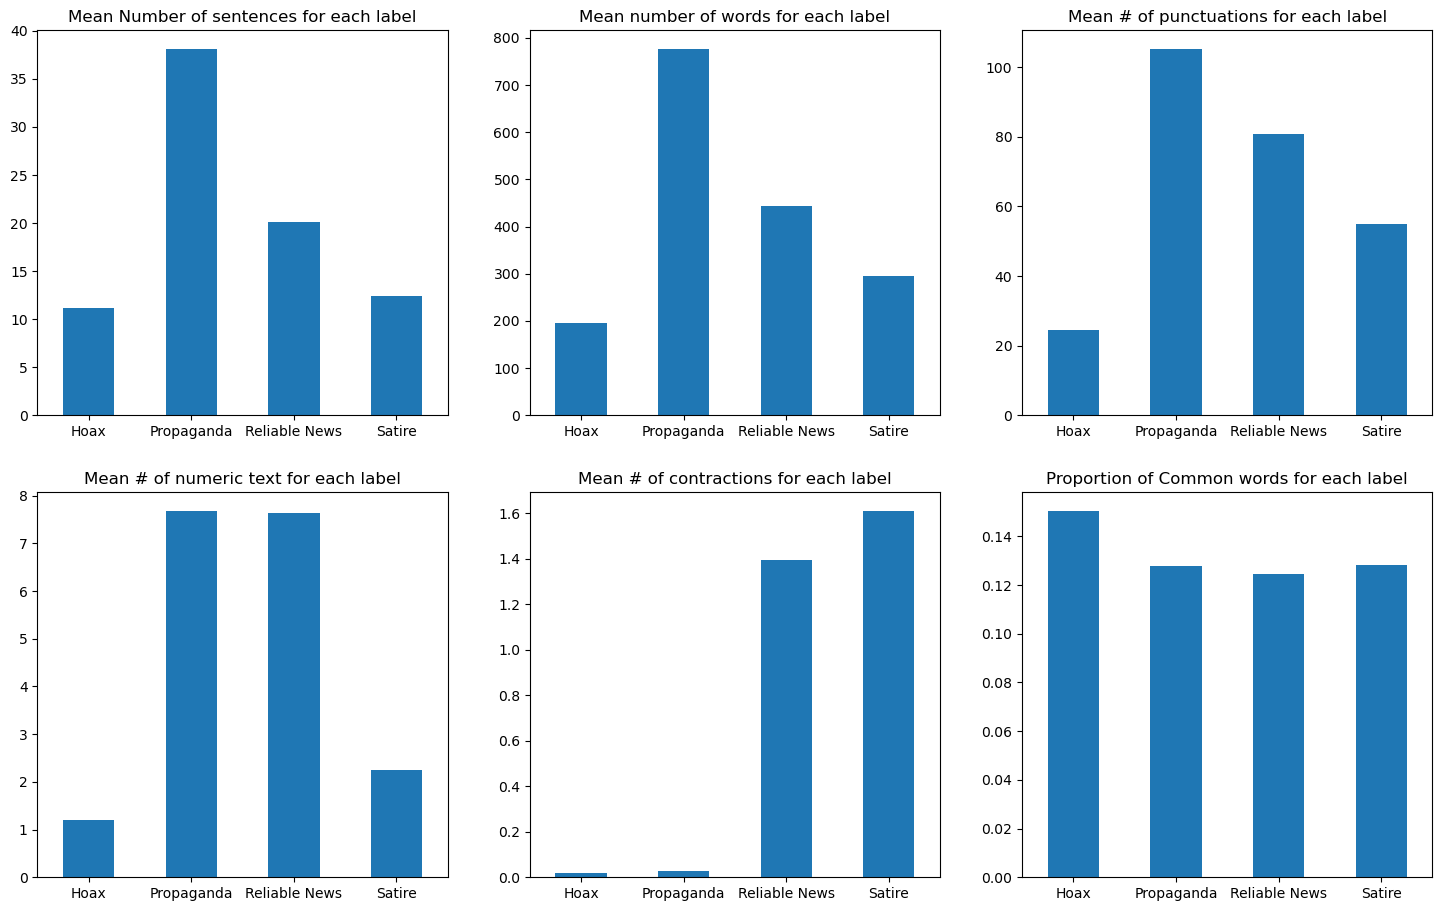

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (18, 11))

grp_by_attr(feature_df, "num_sentences").plot(kind = "bar", xlabel = "", ax = axes[0,0], title = "Mean Number of sentences for each label", rot = 0)
grp_by_attr(feature_df, "num_words").plot(kind = "bar", xlabel = "", ax = axes[0,1], title = "Mean number of words for each label", rot = 0)
grp_by_attr(feature_df, "num_numeric").plot(kind = "bar", xlabel = "", ax = axes[1,0], title = "Mean # of numeric text for each label", rot = 0)
grp_by_attr(feature_df, "num_contractions").plot(kind = "bar", xlabel = "", ax = axes[1,1], title = "Mean # of contractions for each label", rot = 0)
grp_by_attr(feature_df, "num_punctuation").plot(kind = "bar", xlabel = "", ax = axes[0,2], title = "Mean # of punctuations for each label", rot = 0)
grp_by_attr(feature_df, "common_words_ratio").plot(kind = "bar", xlabel = "", ax = axes[1,2], title = "Proportion of Common words for each label", rot = 0)



In [ ]:
# Trend plots 
fig, axes = plt.subplots(2,3, figsize=(16, 11))

sns.regplot(ax = axes[0][0], x = cleaned_stats["annualized_vol"], y = cleaned_stats["annualized_rtn"])

#### Wordcloud

In [148]:
combined_text = " ".join([each_text for each_text in df["Text"]])
all_common_words = Counter(combined_text.split(" ")).most_common()

In [ ]:
def get_top_k(all_words, k = 25):
#     All words as retrieved from Counter().most_common()
    top_1000 = [word[0] for word_pair in all_common_words]

In [149]:
from wordcloud import WordCloud


# text = open(path.join(d, 'constitution.txt')).read()

# Generate a word cloud image
wordcloud = WordCloud().generate(combined_text)

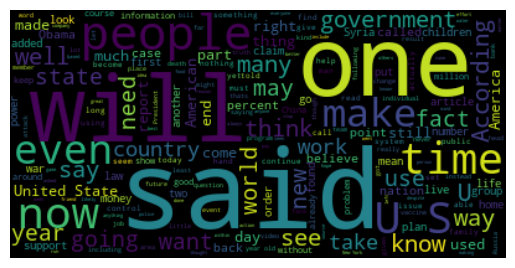

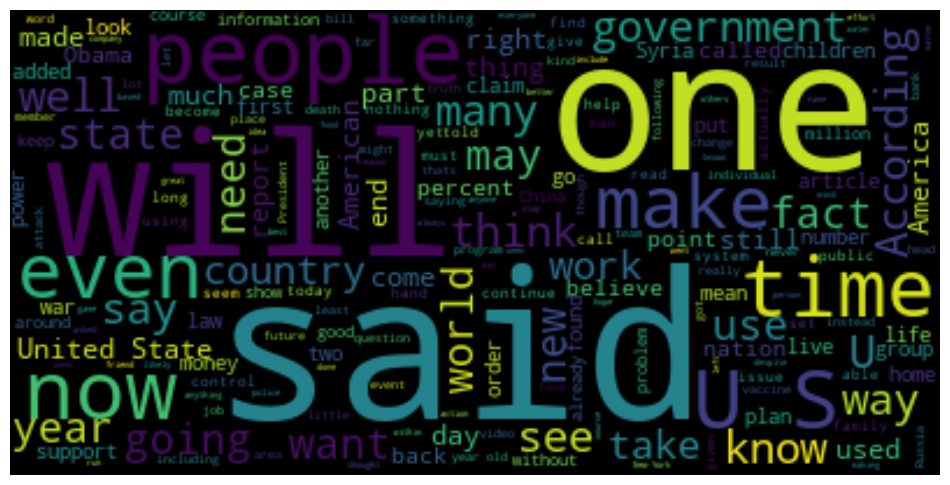

In [152]:
# Display the generated image:
# the matplotlib way:

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
plt.figure(figsize = (12, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Creating word embeddings

In [15]:
normal_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# For bigger word vectors possibly with more accuracy but significantly longer processing
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5") 


In [16]:
# text_embed = normal_embed(np.array(df["Text"]))

def generate_large_embed(data, large = False):
    list_numpy = []
    warning = input("WARNING! Running will take quite long (~1-3 min). Do you want to continue [y/n]:")
    if warning == "y":
        for i in range(1, 1000):
            if i%10 == 0:
                print(i)
            start_id = (i - 1) * 50
            end_id = i * 50
            try:

                if large:
                    list_numpy.append(embed(data["Text"][start_id:end_id]).numpy())
                else:
                    list_numpy.append(normal_embed(data["Text"][start_id:end_id]).numpy())
            
            except:
                continue

            if end_id > len(data):
                break

        return list_numpy
    
    else:
        return None
    


In [21]:
test_embed = generate_large_embed(test_df, False)

WARNING! Running will take quite long (~1-3 min). Do you want to continue [y/n]:y
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [37]:
# normal_test_embed = np.concatenate(test_embed, axis = 0)
# normal_test_embed.shape
# np.save("test_embed.npy", normal_test_embed)

In [40]:
# normal_embed = np.concatenate(text_embed, axis = 0)
# np.save("normal_embed.npy", normal_embed)
# 512 dimension
normal_embed_vector = np.load("normal_embed.npy")
normal_test_embed = np.load("test_embed.npy")

In [ ]:
# large_embed = np.concatenate(text_embed, axis = 0)
# np.save("large_embed.npy", large_embed)

# large_embed_vector = np.load("large_embed.npy")

In [38]:
normal_embed_vector = np.concatenate(text_embed, axis = 0)
normal_embed_vector.shape

(48854, 512)

### Training The Model

In [41]:
from sklearn import svm
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(normal_embed_vector, train_labels, test_size=0.2, random_state=42)


In [56]:
from sklearn.metrics import confusion_matrix

def get_f1_score(fitted_model, x_val, y_actual):
#     inputs: fitted model, x validate and y actual
    assert len(y_actual) == len(x_val)
    y_pred = fitted_model.predict(x_val)
    predictions_acc = y_pred == y_actual 
    blended_acc = np.count_nonzero(predictions_acc)/len(y_actual)
    print(np.unique(y_pred, return_counts = True))
    print(f"Overall accuracy: {blended_acc}")
    cm = confusion_matrix(y_actual, y_pred)
    print(cm)
    
    return f1_score(y_pred, y_actual, average = "macro")

def train_model(feature_data, labels, model_type, iters = 300, state = 42):
    """
    Trains logistic regression model given x (features) and y data (labels)
    returns trained_model
    """
#     x_val would be OOS (unseen)
    x_train, x_val, y_train, y_val = train_test_split(feature_data, labels, test_size=0.2, random_state=state)

    if model_type == "l":
        ml_model = LogisticRegression(multi_class = "multinomial", max_iter = iters)
        ml_model.fit(x_train, y_train)
    elif model_type == "n":
        # neural network
        ml_model = MLPClassifier(random_state=state, max_iter=iters, early_stopping = True, learning_rate = "adaptive")
        ml_model.fit(x_train, y_train)
    elif model_type == "nb":
        scaler = MinMaxScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        ml_model =  MultinomialNB(alpha=0.1)
        ml_model.fit(x_train_scaled, y_train)
        
    insample = get_f1_score(ml_model, x_train, y_train)
    outofsample = get_f1_score(ml_model, x_val, y_val)
    print(f"Insample F1 :{insample:.3f}")
    print(f"OOS F1 :{outofsample}")
    
    return ml_model

In [57]:
train_model(normal_embed_vector, train_labels, "l")

(array([1, 2, 3, 4], dtype=int64), array([11337,  5546, 14474,  7726], dtype=int64))
Overall accuracy: 0.9379269759230356
[[10574   152   240   288]
 [  152  5229   121    69]
 [  200   106 13731   246]
 [  411    59   382  7123]]
(array([1, 2, 3, 4], dtype=int64), array([2822, 1352, 3639, 1958], dtype=int64))
Overall accuracy: 0.9302016170299867
[[2618   36   77   62]
 [  45 1266   37   23]
 [  50   31 3419   87]
 [ 109   19  106 1786]]
Insample F1 :0.935
OOS F1 :0.9266506685316978


LogisticRegression(max_iter=300, multi_class='multinomial')

In [58]:
mlp_model = train_model(normal_embed_vector, train_labels, "n", state = 42)

(array([1, 2, 3, 4], dtype=int64), array([11220,  5627, 14373,  7863], dtype=int64))
Overall accuracy: 0.9701660568533633
[[10891    98   103   162]
 [   46  5446    60    19]
 [   81    56 14022   124]
 [  202    27   188  7558]]
(array([1, 2, 3, 4], dtype=int64), array([2828, 1348, 3619, 1976], dtype=int64))
Overall accuracy: 0.9414594207348276
[[2651   33   51   58]
 [  44 1276   36   15]
 [  41   27 3444   75]
 [  92   12   88 1828]]
Insample F1 :0.969
OOS F1 :0.9381534789685754


#### OUT OF SAMPLE TEST RESULTS

In [69]:
# actual labels
np.unique(test_df_labels, return_counts = True)

(array([1, 2, 3, 4], dtype=int64), array([750, 750, 750, 750], dtype=int64))

In [70]:
# Predicted labels
np.unique(mlp_model.predict(normal_test_embed), return_counts = True)

(array([1, 2, 3, 4], dtype=int64),
 array([ 670,  478, 1012,  840], dtype=int64))

In [61]:
f1_score(mlp_model.predict(normal_test_embed), test_df_labels, average = "macro")

0.7044641651776254

In [65]:
cm = confusion_matrix(test_df_labels, mlp_model.predict(normal_test_embed))
row_sum = np.sum(cm, axis = 1)
100 * cm/row_sum

array([[74.13333333, 17.2       ,  4.93333333,  3.73333333],
       [ 6.53333333, 43.73333333, 42.8       ,  6.93333333],
       [ 3.33333333,  0.93333333, 80.66666667, 15.06666667],
       [ 5.33333333,  1.86666667,  6.53333333, 86.26666667]])

#### Training on XGBoost Model

In [31]:
from xgboost import XGBClassifier
import xgboost as xgb
# read data
from sklearn.model_selection import train_test_split

# create model instance
bst = XGBClassifier(n_estimators=10, max_depth=20, learning_rate=0.01, objective="multi:softmax", verbosity = 2)
# fit model
bst.fit(x_train, y_train - 1)


[23:40:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2312 extra nodes, 0 pruned nodes, max_depth=20
[23:40:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1336 extra nodes, 0 pruned nodes, max_depth=20
[23:40:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2460 extra nodes, 0 pruned nodes, max_depth=20
[23:40:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2300 extra nodes, 0 pruned nodes, max_depth=20
[23:40:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2346 extra nodes, 0 pruned nodes, max_depth=20
[23:40:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1340 extra nodes, 0 p

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [32]:
# make predictions
preds = bst.predict(x_val)
preds
confusion_matrix(y_val - 1, preds)

array([[2388,   96,  170,  139],
       [ 123, 1124,   72,   52],
       [ 147,   84, 3175,  181],
       [ 185,   52,  232, 1551]], dtype=int64)

In [33]:
f1_score(preds, y_val - 1, average = "macro")

0.834006474858285